In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import networkx as nx

%matplotlib inline

---
Let's say we want to represent the situation in a film of CNT as a mathematical graph (with nodes and lines). Make some simplifying assumptions:
1. There is a resistance at each **node** (this corresponds with our greatly simplified picture of the physical reality)
2. There is no resistance in the lines; just in the connections
3. Each CNT intersects with exactly two others

Developing this idea:
* There are only ever two CNT involved at each node, meaning maximum four lines connected to the node.
    * Problem: resistance should be zero when staying on the same CNT but not zero when jumping from one to another.
    

Oh goodness this is very complex.

Ok figure that out later, let's code *something*. 


[Wikipedia: Nodal Analysis](https://en.wikipedia.org/wiki/Nodal_analysis)

Nodal analysis is based on Kirchhoff's Current Law, which says the sum of currents at a node is zero. Note positive currents come toward the node and negative currents go away from the node.
$$V=IR$$
$$I = \frac{V}{R}$$


Sample network

![img](https://dl2.pushbulletusercontent.com/vbQLyBgJMAF46sICGIOBqQGxrFnbvJFe/IMG_8700.JPG)

In [2]:
#nx.draw(example_graph, with_labels=True, font_weight='bold')

In [3]:
# We will use the wonderfully useful library networkx to allow us
# to represent graphs in a nice way.

example_graph = nx.Graph()
example_graph.clear()
example_graph.add_nodes_from(list("ABCDEF"), current=0.) # initialize with all current = 0.
edges = [
    ('A', 'B', {'resistance': 10.}),
    ('A', 'C', {'resistance': 1.}),
    ('B', 'C', {'resistance': 3.}),
    ('B', 'D', {'resistance': 100.}),
    ('C', 'F', {'resistance': 1.}),
    ('D', 'E', {'resistance': 4.}),
    ('D', 'F', {'resistance': 1.}),
    ('E', 'F', {'resistance': 15.}),
]

example_graph.add_edges_from(edges)

In [4]:
# we can assign a current at the two nodes we want to examine,
# and leave zero current at the others:


def set_currents(graph, check_nodes):
    """
    Takes a graph list of two nodes in that graph.
    Sets current of +1A at one of the nodes and -1A at the other
    to prepare for nodal analysis. Returns the new graph.
    """
    first_node = True
    for node in check_nodes:
        try:
            if first_node:
                graph.nodes[node]['current'] = 1.
                first_node = False
            else:
                graph.nodes[node]['current'] = -1.
        except KeyError:
            print("Illegal node given as start or endpoint!")
            raise
    return graph


In [6]:
nodei = 'B'
neighbors = list(example_graph.neighbors(nodei))
print(neighbors)

for x in neighbors:
    print(example_graph.edges[x,nodei]['resistance'])

Gij = 1./sum(example_graph.edges[x,nodei]['resistance'] for x in neighbors)
Gij

['A', 'C', 'D']
10.0
3.0
100.0


0.008849557522123894

We want to make a matrix in the following form:

 | | | | 
---|---|---|---|---
G_11|G_12|G_13|...|G_1N
G_21|G_22|...|...|G_2N
...|...|...|...|...
G_N1|G_N2|...|...|G_NN

Where in this case we'll use the DC simplification
$G=\frac{1}{R}$

And we know $G_{ii}$ is the sum of $G$s connected to node $i$

~~And also that $G_{ij}$ is the negative sum of $G$s between $i$ and $j$~~

From the paper ["Modeling percolation..."](http://www.mdpi.com/1996-1944/8/10/5334), we read that $G_{ij}=0$ except when $i$ and $j$ have a *direct* connection by one resistor. When they do have a direct connection, $G_{ij} = -\frac{1}{R_{ij}}$

(note, this may be a simplification the authors of that paper used[{?}])

In [7]:


def G_matrix(graph):
    """
    Returns a matrix of the conductances G[i][j], given a networkx graph
    whose edges hold resistance data.
    """
    num_nodes = len(graph.nodes)
    G = np.zeros((num_nodes, num_nodes))
    
    i = 0
    for nodei in graph:
        j = 0
        for nodej in graph:
            # if the element is on the diagonal, Gjj is the reciprocal
            # of the sum of the resistances attached to node j
            if i == j:
                Gij = 1./sum(graph.edges[x, nodei]['resistance'] for x in list(graph.neighbors(nodei)))
                G[i][j] = Gij
            # if the element is above the diagonal, Gij is the negative reciprocal
            # of Rij (if an edge ij exists). If not, Gij stays 0.
            elif i < j:
                try:
                    Gij = 1./graph.edges[nodei, nodej]['resistance']
                    G[i][j] = Gij
                except KeyError:
                    pass
            # if the element is below the diagonal, use symmetry, i.e. Gij = Gji
            else:
                G[i][j] = G[j][i]
            j += 1
        i += 1
    return G


To calculate the equivalent resistance between two points in the graph, here's a cno

In [8]:
########################################################
### up to here is what I've refactored into networkx ###
########################################################

In [58]:
def equivalent_resistance(graph, check_nodes):
    """
    Given a graph and a list of two check nodes,
    computes the equivalent resistance.
    """
    # put a 1A current at one check node and a -1A current at the other
    graph = set_currents(graph, check_nodes)
    
    # get the matrix of conductances, G[i][j]
    G = G_matrix(graph)
    
    # get the matrix of currents, I
    I = np.array(list(graph.nodes[x]['current'] for x in graph.nodes))
    
    # run np.linalg.solve to get the matrix of voltages
    V = np.linalg.solve(G, I)
    
    print(G)
    print(I)
    print(V)
    
    # use a simple numpy operation to compute the equivalent resistance
    equivalent_resistance = abs(sum(I*V))
    return equivalent_resistance
    





In [47]:
example_graph = nx.Graph()
example_graph.clear()
example_graph.add_nodes_from(list("ABCDEF"), current=0.) # initialize with all current = 0.
edges = [
    ('A', 'B', {'resistance': 10.}),
    ('A', 'C', {'resistance': 1.}),
    ('B', 'C', {'resistance': 3.}),
    ('B', 'D', {'resistance': 100.}),
    ('C', 'F', {'resistance': 1.}),
    ('D', 'E', {'resistance': 4.}),
    ('D', 'F', {'resistance': 1.}),
    ('E', 'F', {'resistance': 15.}),
]

example_graph.add_edges_from(edges)

check_nodes = list("AF")
check_nodeses = list(example_graph.edges)

for cn in check_nodeses:
    er = equivalent_resistance(example_graph, cn)
    print("Check nodes: {}. The calculated equivalent resistance is {:.2f} V".format(cn, er))

Check nodes: ('A', 'B'). The calculated equivalent resistance is 36.28 V
Check nodes: ('A', 'C'). The calculated equivalent resistance is 35.01 V
Check nodes: ('B', 'C'). The calculated equivalent resistance is 6.02 V
Check nodes: ('B', 'D'). The calculated equivalent resistance is 1.59 V
Check nodes: ('C', 'F'). The calculated equivalent resistance is 13.34 V
Check nodes: ('D', 'E'). The calculated equivalent resistance is 11.07 V
Check nodes: ('D', 'F'). The calculated equivalent resistance is 11.07 V
Check nodes: ('E', 'F'). The calculated equivalent resistance is 70.43 V


## Procedure for using this on an arbitrary graph of resistors:
1. Construct a graph using `graph = nx.Graph()`, `graph.add_nodes_from`, and `graph.add_edges_from`.
    * Each node should have a 'current' attribute, set to 0.
    * Each edge should have a 'resistance' attribute, set to the resistance of the resistor it represents.
    * Syntax:

    ```
    graph.add_nodes_from([list, of, node, names], current=0.)
    ```

    ```
    graph.add_edges_from([
        (node1, node2, {'resistance': 1111.}),
        (node1, node2, {'resistance': 1111.}),
        (node1, node2, {'resistance': 1111.})
            ])
    ```

2. Define the two nodes between which equivalent resistance will be calculated. Use a two-element list or similar.

3. Run `equivalent_resistance(graph, check_nodes)` to get the answer!

16.6821705426


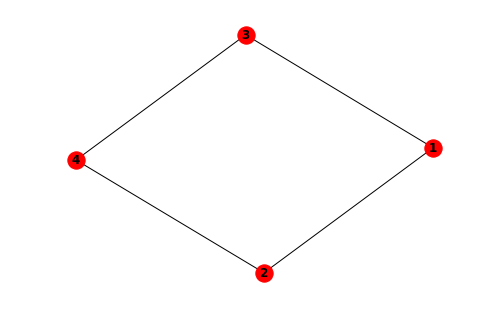

In [54]:
# Now that this seems to work, we should do some testing.

graphA = nx.Graph()
graphA.clear
graphA.add_nodes_from((1,2,3,4), current=0.)
edges = [
    (1, 2, {'resistance': 2.}),
    (4, 2, {'resistance': 1.}),
    (1, 3, {'resistance': 3.}),
    (3, 4, {'resistance': 3.})
]
graphA.add_edges_from(edges)

check_nodes = (1, 4)

eq_r = equivalent_resistance(graphA, check_nodes)
print(eq_r)

nx.draw(graphA, with_labels=True, font_weight='bold')

[[ 0.5   0.5   0.    0.  ]
 [ 0.5   0.25  0.5   0.  ]
 [ 0.    0.5   0.25  0.5 ]
 [ 0.    0.    0.5   0.5 ]]
[ 1.  0. -1.  0.]
[ 6. -4. -4.  4.]
10.0


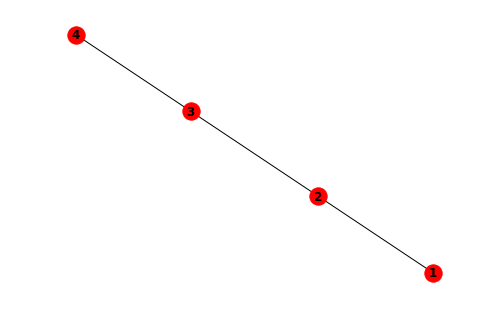

In [63]:


graphB = nx.Graph()
graphB.clear
graphB.add_nodes_from((1,2,3,4), current=0.)
edges = [
    (1, 2, {'resistance': 2.}),
    (2, 3, {'resistance': 2.}),
    (3, 4, {'resistance': 2.})
]
graphB.add_edges_from(edges)

check_nodes = (1, 3)

eq_r = equivalent_resistance(graphB, check_nodes)
print(eq_r)

nx.draw(graphB, with_labels=True, font_weight='bold')

In [ ]:
# The two above both fail, and that is a bummer.